# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import time
import os, platform
import itertools
from datetime import datetime

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [6]:
if platform.system()=='Darwin':
    path = '/Users/phil/Google Drive/projects/nfl/data/all'
elif os.environ.get("USERNAME")=='phil':
    path = 'C:/Users/phil/Google Drive/nfl/data/all'
elif os.environ.get("USERNAME")=='LYNCP010':
    path = 'C:/Users/lyncp010/projects/nfl/data'
print (path)

C:/Users/lyncp010/projects/nfl/data


# DATA

In [7]:
offense_player_ff_points = pd.read_csv(path + '/all/offense_player_ff_points_s02w01_s16w21.csv', low_memory=False)

In [8]:
# use only players from current season
df = offense_player_ff_points[(offense_player_ff_points.season == 2016)].copy()

In [9]:
df.head()

,season,week,bsID,team,player_id,position,ff_points_total,home,opponent,passAtt,...,recLong,rushAtt,rushYds,rushTd,rushLong,fumbles,fumblesLost,passYdsOver300,rushYdsOver100,recYdsOver100
71153,2016,1,201609080den,car,BenjKe00,WR,15.10,0,den,0.0,...,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
71154,2016,1,201609080den,car,BrowPh00,WR,1.10,0,den,0.0,...,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
71155,2016,1,201609080den,car,FuncDe00,WR,0.90,0,den,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
71156,2016,1,201609080den,car,GinnTe00,WR,2.50,0,den,0.0,...,5.0,1.0,20.0,0.0,20.0,0.0,0.0,0,0,0
71157,2016,1,201609080den,car,NewtCa00,QB,22.16,0,den,33.0,...,0.0,11.0,54.0,1.0,12.0,0.0,0.0,0,0,0


In [11]:
for c in df.columns: print (c)

season
week
bsID
team
player_id
position
ff_points_total
home
opponent
passAtt
passCmp
passYds
passTds
passLong
passRating
passSacked
passSackedYds
passInt
targets
rec
recYds
recTds
recLong
rushAtt
rushYds
rushTd
rushLong
fumbles
fumblesLost
passYdsOver300
rushYdsOver100
recYdsOver100


# PRE PROCESSING

## creating ids

In [12]:
from sklearn import preprocessing

#### team ids

In [13]:
# create index for team names
team_list = np.sort(df['team'].unique())
team_le = preprocessing.LabelEncoder()
team_le.fit(team_list)

# add team ids
df['opponent_id'] = team_le.transform(df['opponent'])

#### player ids

In [14]:
# create index for team names
player_list = np.sort(df['player_id'].unique())
player_le = preprocessing.LabelEncoder()
player_le.fit(player_list)

# add team ids
df['player_n_id'] = player_le.transform(df['player_id'])

### splitting data

In [15]:
# create train testing index for each game.
np.random.seed(7)

kfolds = 5

df['kfold'] = np.random.choice(kfolds, size=len(df), )

# MODEL

#### matrix factorization w/ gradient descent

$$
\hat{y_{i,j}} = \beta_0 + \beta_1 * Home_i + P_i \cdot O_j
$$

In [31]:
def player_oppo_mfsgd(dtrain, dtest=False, latent_features=2, max_iter=500, learning_rate=0.0001, beta=0.01, mu=0.8, seed=0):
    
    np.random.seed(seed)
    team_size = len(team_list)
    player_size = len(player_list)
    rmse = []
    rmse_test = []
    
    eps = 1e-5
    err_lim = 1e6
    
    vB, vP, vO = 0, 0, 0 # velocity starts 0
    
    # expansion matrix
    player_expansion = np.eye(player_size)
    oppo_expansion = np.eye(team_size)
    
    # initialize weights
    # B = np.random.rand(2) # bias + home_indicator
    B = np.c_[df['ff_points_total'].mean(), np.random.rand(1)].reshape(2,) # global_bias + home_indicator
    P = np.random.rand(player_size, latent_features) # player weights
    P = np.maximum(P, eps)
    O = np.random.rand(team_size, latent_features) # opponent weights
    O = np.maximum(O, eps)
    
    # training data
    X = np.c_[np.ones(len(dtrain)), dtrain['home'].as_matrix()]
    y = dtrain['ff_points_total'].as_matrix()
    
    # testing data
    if type(dtest)!=bool:
        X_test = np.c_[np.ones(len(dtest)), dtest['home'].as_matrix()]
        y_test = dtest['ff_points_total'].as_matrix()
    
    for i in range(max_iter):
        #print '\rStep {}/{}'.format(i+1, max_iter),
        
        # embeddings for mf
        player_embed = P[dtrain['player_n_id'].as_matrix(),:]
        oppo_embed = O[dtrain['opponent_id'].as_matrix(),:]

        # calc y_hat
        y_hat = np.dot(X, B) + np.einsum('ij,ji->i', player_embed, oppo_embed.T)

        # calc errors
        e = y - y_hat

        # ---- derivatives ----
        # betas
        B_deriv = (np.c_[(-e),(-e)] * X).sum(axis=0)

        # latent factors
        P_deriv = np.dot(np.array([(-e) for _ in range(latent_features)]) * oppo_embed.T,
                         player_expansion[dtrain['player_n_id'].as_matrix(),:]
                        ).T
        O_deriv = np.dot(np.array([(-e) for _ in range(latent_features)]) * player_embed.T,
                         oppo_expansion[dtrain['opponent_id'].as_matrix(),:]
                        ).T
        
        # OPTION - add regularization
        B_deriv -= beta * B
        P_deriv -= beta * P
        O_deriv -= beta * O
        
        # OPTION - use MacKays quick n' dirty variance ratio
        # var_resid = np.var(e)
        # beta_P = P.var()/var_resid
        # beta_O = O.var()/var_resid
        # P_deriv -= (beta_P * P) + (beta * P)
        # O_deriv -= (beta_O * O) + (beta * O)
        
        # ---- parameter updates ----
        B -= learning_rate * B_deriv
        P -= learning_rate * P_deriv
        O -= learning_rate * O_deriv
        
        # OPTION - add momentum
        vB = mu * vB - learning_rate * B_deriv
        vP = mu * vP - learning_rate * P_deriv
        vO = mu * vO - learning_rate * O_deriv
        B += mu * vB
        P += mu * vP
        O += mu * vO
        
        # save error
        # - training
        rmse_i = np.sqrt(np.mean(e**2))
        rmse.append(rmse_i)
        
        # - test error
        if type(dtest)!=bool:
            player_embed_test = P[dtest['player_n_id'].as_matrix(),:]
            oppo_embed_test = O[dtest['opponent_id'].as_matrix(),:]
            y_hat_test = np.dot(X_test, B) + np.einsum('ij,ji->i', player_embed_test, oppo_embed_test.T)
            e_test = y_test - y_hat_test
            rmse_test_i = np.sqrt(np.mean(e_test**2))
            rmse_test.append(rmse_test_i)
        
        if rmse_i > err_lim:
            #print '\nError limit reached :('
            rmse += [np.nan]*(max_iter - i - 1)
            rmse_test += [np.nan]*(max_iter - i - 1)
            break
    
    # return results if not using test set
    if type(dtest)==bool:
        print ('\rDone!')
        return B, P, O, rmse
    else:
        rmse_test = pd.Series(rmse_test, index=range(1, max_iter + 1))
        rmse_test.index.names = ['iter']
        return rmse_test

In [18]:
def split_data_to_train_test(df, index, fold):
    df_train = df[(df[index]!=fold)]
    df_test =  df[(df[index]==fold)]
    return df_train, df_test

In [19]:
def kfold_cv(data, nfolds, latent_features, max_iter, learning_rate, beta, mu):
    # results df
    model_i = pd.DataFrame()
    
    # loop over folds
    for fold in range(nfolds):
        # create train test set
        trn, tst = split_data_to_train_test(data, 'kfold', fold)
        # train matrix factorization
        model_i['rmse_fold_{}'.format(fold)] = player_oppo_mfsgd(trn, tst,
                                                                 latent_features = latent_features,
                                                                 learning_rate = learning_rate,
                                                                 max_iter = max_iter,
                                                                 beta = beta,
                                                                 mu = mu
                                                                )
        
    # set hyper param indices
    model_i['position'] = p
    model_i['latent_features'] = lf
    model_i['learning_rate'] = learning_rate
    model_i['beta'] = beta
    model_i['mu'] = mu
    model_i.reset_index(inplace=True)
    model_i.set_index(['position', 'latent_features', 'learning_rate', 'beta', 'mu', 'iter'], inplace=True)
    
    # return results
    return model_i

In [20]:
def score_player_oppo(data, B, P, O):
    # embeddings for mf
    X = np.c_[np.ones(len(data)), data['home'].as_matrix()]
    player_embed = P[player_le.transform(data['player_id']),:]
    oppo_embed = O[team_le.transform(data['opponent']),:]

    # calc y_hat
    y_hat = np.dot(X, B) + np.einsum('ij,ji->i', player_embed, oppo_embed.T)
    
    return y_hat

# TRAINING

## hyper parameters

In [28]:
# use only regular season for training
df_train = df[(df.week <= 17)].copy()

In [29]:
# index of results parameters
offense_positions = ['QB', 'RB', 'TE', 'WR']

max_latent_features = 4
latent_features_list = range(1, max_latent_features+1)

max_iter = 300
max_iter_list = range(1, max_iter+1)

In [109]:
# list of hyper param
grid = {
    'lf':latent_features_list,
    'learning_rate':[0.0001, 0.001, 0.005, 0.01],
    'beta':[0.0, 0.005, 0.01, 0.02],
    'mu':[0.0, 0.3, 0.5, 0.8]
}

# number of grid combincations
grid_n = 1
for key in grid.keys():
    grid_n *= len(grid[key])
print '{} combinations'.format(grid_n)
grid

256 combinations


{'beta': [0.0, 0.005, 0.01, 0.02],
 'learning_rate': [0.0001, 0.001, 0.005, 0.01],
 'lf': [1, 2, 3, 4],
 'mu': [0.0, 0.3, 0.5, 0.8]}

## kfold testing on all hyper parameters

In [59]:
# time training
start = time.time()

# create empty dataframe for results
model_results = pd.DataFrame()

print 'Training...'
for p in offense_positions:
    
    data = df[df['position']==p].copy()
    for i, gs in enumerate(itertools.islice(itertools.product(
                grid['lf'],
                grid['learning_rate'],
                grid['beta'],
                grid['mu']
            ), grid_n)):
        latent_features = gs[0]
        learning_rate = gs[1]
        beta = gs[2]
        mu = gs[3]
        print '\r({}/{}) Position {} - lf {} - learning_rate {} - beta {} - mu {}'.format(i+1, grid_n * 4,
                                                                                  p, lf, learning_rate, beta, mu),
        
        n_folds = len(data['kfold'].unique())
        
        model_results_i = kfold_cv(data, n_folds, latent_features, max_iter, learning_rate, beta, mu)        
        model_results = pd.concat([model_results, model_results_i])

print '\rDone! Total run time: {}'.format(time.time() - start)

Training...
Done! Total run time: 4033.88900018


In [60]:
model_results.dropna(inplace=True)
model_results['rmse_fold_avg'] = model_results.mean(axis=1)

In [64]:
# create dictionary of best parameters for each position
best_param = {}
for p in offense_positions:
    best_param_pos = model_results.loc[idx[p,:,:,:,:,:],]['rmse_fold_avg'].idxmin()
    best_param[best_param_pos[0]] = {'lf'   : best_param_pos[1],
                                     'learning_rate': round(best_param_pos[2], 4),
                                     'beta' : round(best_param_pos[3], 2),
                                     'mu'   : round(best_param_pos[4], 1),
                                     'iter' : best_param_pos[5]
                                    }
best_param

{'QB': {'beta': 0.0, 'iter': 500, 'learning_rate': 0.001, 'lf': 1, 'mu': 0.8},
 'RB': {'beta': 0.0, 'iter': 398, 'learning_rate': 0.0001, 'lf': 3, 'mu': 0.0},
 'TE': {'beta': 0.0, 'iter': 440, 'learning_rate': 0.0001, 'lf': 2, 'mu': 0.0},
 'WR': {'beta': 0.0, 'iter': 467, 'learning_rate': 0.0001, 'lf': 1, 'mu': 0.5}}

In [65]:
# print top 5 best results for each position
gb = model_results.groupby(level=[0])['rmse_fold_avg']
gb.nsmallest(5)

position  position  latent_features  learning_rate  beta   mu   iter
QB        QB        1                0.0010         0.000  0.8  500     7.082935
                                                                499     7.083011
                                                                498     7.083087
                                                    0.005  0.8  500     7.083131
                                                    0.000  0.8  497     7.083163
RB        RB        3                0.0001         0.000  0.0  398     5.795136
                                                                399     5.795138
                                                                397     5.795141
                                                                400     5.795147
                                                                396     5.795151
TE        TE        2                0.0001         0.000  0.0  440     4.192730
                                        

In [24]:
best_param = {
    'QB': {'beta': 0.0, 'iter': 500, 'learning_rate': 0.001, 'lf': 1, 'mu': 0.8},
    'RB': {'beta': 0.0, 'iter': 398, 'learning_rate': 0.0001, 'lf': 3, 'mu': 0.0},
    'TE': {'beta': 0.0, 'iter': 440, 'learning_rate': 0.0001, 'lf': 2, 'mu': 0.0},
    'WR': {'beta': 0.0, 'iter': 467, 'learning_rate': 0.0001, 'lf': 1, 'mu': 0.5}
}

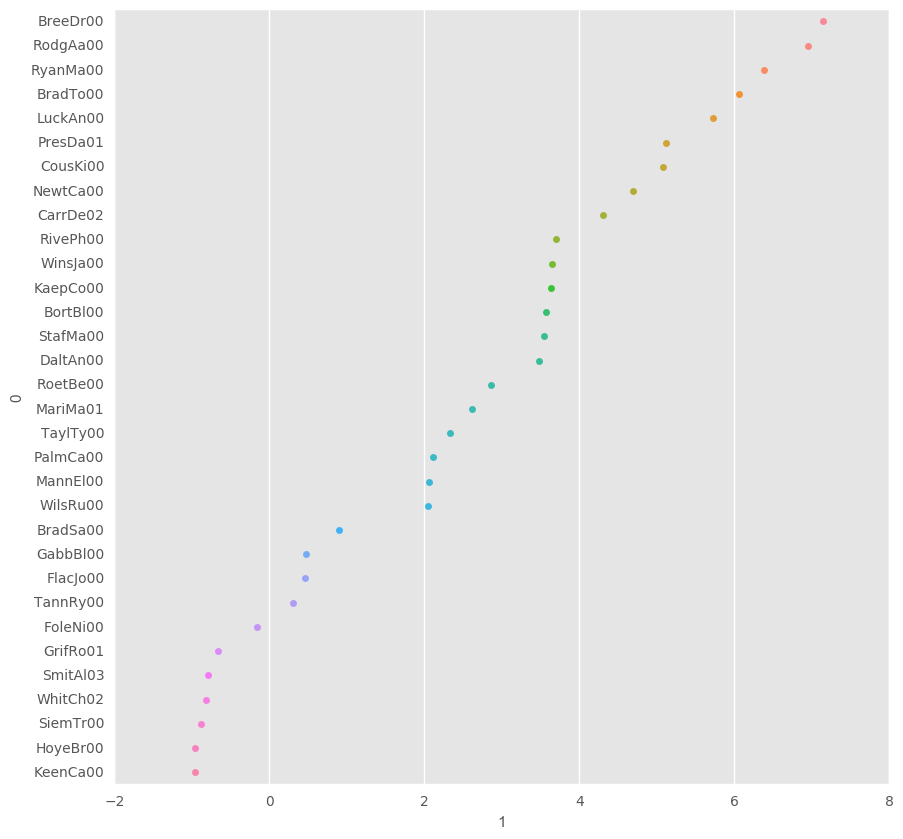

In [196]:
plt.figure(figsize=(10, 10))
sns.stripplot(x=1, y=0, data=pd.DataFrame([X_Player.columns, alpha]).T.sort_values(1, ascending=False).head(32))

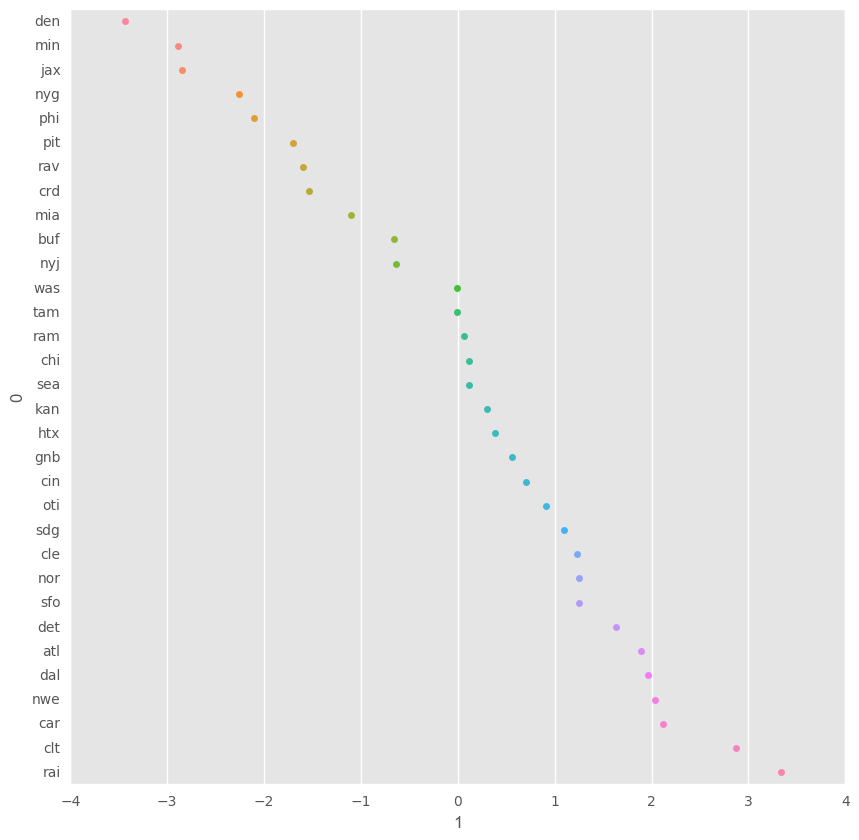

In [199]:
plt.figure(figsize=(10, 10))
sns.stripplot(x=1, y=0, data=pd.DataFrame([X_Opponent.columns, tau]).T.sort_values(1, ascending=True).head(32))

# SCORE PLAYOFFS

In [25]:
from sklearn.metrics import mean_squared_error
def RMSE(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))

### test on playoff games

In [26]:
# test on playoff games
df_test = df[(df.week > 17)].copy()

In [36]:
for p in offense_positions:
    B, P, O, rmse = player_oppo_mfsgd(df_train[df_train['position']==p],
                                      latent_features = best_param[p]['lf'],
                                      max_iter = best_param[p]['iter'],
                                      learning_rate = best_param[p]['learning_rate'],
                                      beta = best_param[p]['beta'],
                                      mu = best_param[p]['mu']
                                     )
    
    df_test.loc[df_test['position']==p, 'p_ff_points_total'] = score_player_oppo(df_test.loc[df_test['position']==p], B, P, O)

Done!
Done!
Done!
Done!


In [37]:
for p in offense_positions:
    print (p, RMSE(df_test.loc[df_test['position']==p, 'ff_points_total'],
                  df_test.loc[df_test['position']==p, 'p_ff_points_total']))

QB 5.70476459881
RB 6.55142424581
TE 4.00277470426
WR 6.24964685997


In [45]:
RMSE(df_test['ff_points_total'], df_test['p_ff_points_total'])**2

35.799926756432981

In [79]:
cols_inspect = ['week', 'bsID', 'team', 'player_id', 'opponent', 'position', 'ff_points_total', 'p_ff_points_total']

In [80]:
df_test.loc[df_test.week==21, cols_inspect]

,week,bsID,team,player_id,opponent,position,ff_points_total,p_ff_points_total
76456,21,201702050atl,atl,ColeTe01,nwe,RB,9.50,8.702194
76457,21,201702050atl,atl,DiMaPa00,nwe,RB,1.20,2.705964
76458,21,201702050atl,atl,FreeDe00,nwe,RB,18.10,10.967133
76459,21,201702050atl,atl,GabrTa00,nwe,WR,7.60,10.066214
76460,21,201702050atl,atl,HoopAu00,nwe,TE,9.20,3.326776
76461,21,201702050atl,atl,JoneJu02,nwe,WR,8.70,13.927646
76462,21,201702050atl,atl,RyanMa00,nwe,QB,18.36,26.597680
76463,21,201702050atl,atl,SanuMo00,nwe,WR,2.50,6.864024
76464,21,201702050atl,nwe,AmenDa00,atl,WR,13.80,3.912960
76465,21,201702050atl,nwe,BennMa00,atl,TE,6.20,7.704795


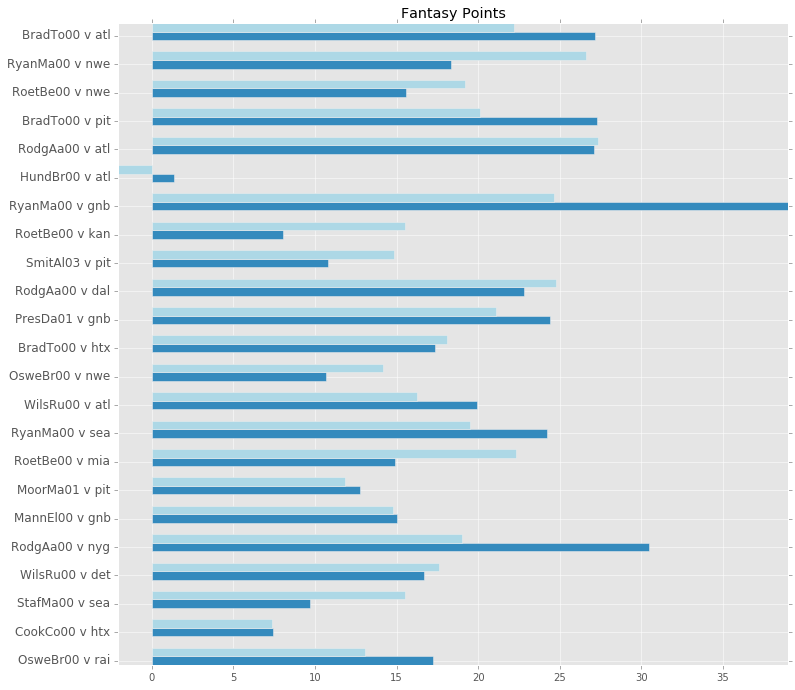

In [101]:
width = 0.3
pos = np.arange(foo.shape[0]) + .5
plt.figure(figsize=(12, foo.shape[0] * .5))
plt.barh(pos, foo['ff_points_total'], height=width, align='center')
plt.barh(pos + width, foo['p_ff_points_total'], height=width, align='center', color='lightblue')
y_ticks = foo[['player_id', 'opponent']].apply(lambda x:'%s v %s' % (x['player_id'],x['opponent']),axis=1)
plt.yticks(pos, y_ticks, fontsize = 12)
plt.axis('tight')
plt.title('Fantasy Points')
plt.show()